# BS1140 SCENIC+

In [ ]:
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
import sys
import os
import imp
import dill
import scanpy as sc
import pandas
import pyranges
# set stderr to null to avoid strange messages from ray
import sys
_stderr = sys.stderr
null = open(os.devnull, 'wb')
work_dir = 'BS1140'

In [ ]:
sys.version

'3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) \n[Clang 13.0.1 ]'

# scATAC-seq preprocessing using pycisTopic

In [ ]:
import pycisTopic
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scATAC')):
    os.makedirs(os.path.join(work_dir, 'scATAC'))


In [ ]:
fragments_dict = {'BS1140': '/Users/jinhuixin/Master/thesis/aligned_raw_data/BS1140/outs/atac_fragments.tsv.gz'}

### Generate pseudobulk ATAC-seq profiles, call peaks and generate a consensus peak set

first load the cell type annotation generated in the scanpy scRNA-seq analysis

In [ ]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata_archr.h5ad'))
cell_data = adata.obs
cell_data['sample_id'] = 'BS1140'
cell_data['celltype'] = cell_data['cluster_archr'].astype(str) # set data type of the celltype column to str
del(adata)

In [ ]:
# generate pseudobulk profiles

# Get chromosome sizes (hg38)
import pyranges as pr
import requests
import pandas as pd
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes = pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns = ['Chromosome','End']
chromsizes['Start'] = [0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome','Start','End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v','.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes = pr.PyRanges(chromsizes)

In [ ]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'celltype',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 bigwig_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 n_cpu = 8,                                                                                 # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 split_pattern = '-')

2022-10-31 14:30:03,614 cisTopic     INFO     Reading fragments from /Users/jinhuixin/Master/thesis/aligned_raw_data/BS1140/outs/atac_fragments.tsv.gz


2022-10-31 14:31:02,314	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


(export_pseudobulk_ray pid=43905) 2022-10-31 14:31:08,258 cisTopic     INFO     Creating pseudobulk for C1_Exhausted_1


(raylet) Spilled 2061 MiB, 3 objects, write throughput 687 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 4123 MiB, 7 objects, write throughput 938 MiB/s.
(raylet) Spilled 8247 MiB, 15 objects, write throughput 1065 MiB/s.


(export_pseudobulk_ray pid=43905) 2022-10-31 14:32:02,701 cisTopic     INFO     C1_Exhausted_1 done!
(export_pseudobulk_ray pid=43905) 2022-10-31 14:32:02,782 cisTopic     INFO     Creating pseudobulk for C2_Exhausted_2
(export_pseudobulk_ray pid=43905) 2022-10-31 14:33:18,580 cisTopic     INFO     C2_Exhausted_2 done!
(export_pseudobulk_ray pid=43905) 2022-10-31 14:33:18,639 cisTopic     INFO     Creating pseudobulk for C9_Memory_2
(export_pseudobulk_ray pid=43905) 2022-10-31 14:33:32,287 cisTopic     INFO     C9_Memory_2 done!
(export_pseudobulk_ray pid=43905) 2022-10-31 14:33:32,568 cisTopic     INFO     Creating pseudobulk for C3_Naive
(export_pseudobulk_ray pid=43905) 2022-10-31 14:33:51,548 cisTopic     INFO     C3_Naive done!
(export_pseudobulk_ray pid=43905) 2022-10-31 14:33:51,643 cisTopic     INFO     Creating pseudobulk for C4_EMRA
(export_pseudobulk_ray pid=43905) 2022-10-31 14:34:14,775 cisTopic     INFO     C4_EMRA done!
(export_pseudobulk_ray pid=43905) 2022-10-31 14:34:

In [ ]:
# save location to bed and bigwig files for later access
import pickle
pickle.dump(bed_paths,open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'),'wb'))
pickle.dump(bw_paths, open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

In [ ]:
# call peaks per pseudobulk profile
import pickle
bed_paths = pickle.load(open(os.path.join(work_dir,'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'),'rb'))
bw_paths = pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path = 'macs2'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                bed_paths,
                                os.path.join(work_dir,'scATAC/consensus_peak_calling/MACS'),
                                genome_size='hs',
                                n_cpu=8,
                                input_format='BEDPE',
                                shift=73,
                                ext_size=146,
                                keep_dup='all',
                                q_value=0.05)

2022-10-31 14:40:36,049	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


(macs_call_peak_ray pid=44145) 2022-10-31 14:40:40,051 cisTopic     INFO     Calling peaks for C1_Exhausted_1 with macs2 callpeak --treatment BS1140/scATAC/consensus_peak_calling/pseudobulk_bed_files/C1_Exhausted_1.bed.gz --name C1_Exhausted_1  --outdir BS1140/scATAC/consensus_peak_calling/MACS --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=44151) 2022-10-31 14:40:40,218 cisTopic     INFO     Calling peaks for C2_Exhausted_2 with macs2 callpeak --treatment BS1140/scATAC/consensus_peak_calling/pseudobulk_bed_files/C2_Exhausted_2.bed.gz --name C2_Exhausted_2  --outdir BS1140/scATAC/consensus_peak_calling/MACS --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=44144) 2022-10-31 14:40:40,268 cisTopic     INFO     Calling peaks for C6_EM_2 with macs2 callpeak --treatment BS1140/scATAC/consensus_peak_calling/pseu

In [ ]:
pickle.dump(narrow_peaks_dict, open(os.path.join(work_dir,'scATAC/consensus_peak_calling/MACS/narrow_peaks_dict.pkl'),'wb'))

In [ ]:
# merge peaks into consensus peak set
from pycisTopic.iterative_peak_calling import *
# Other parameters
peak_half_width = 250
path_to_blacklist='/Users/jinhuixin/Master/thesis/pycisTopic/blacklist/hg38-blacklist.v2.bed'
# get consensus peaks
consensus_peaks = get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes, path_to_blacklist = path_to_blacklist)

2022-10-31 14:41:56,025 cisTopic     INFO     Extending and merging peaks per class
2022-10-31 14:42:15,651 cisTopic     INFO     Normalizing peak scores
2022-10-31 14:42:15,812 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2022-10-31 14:42:31,452 cisTopic     INFO     Done!


In [ ]:
consensus_peaks.to_bed(
    path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'),
    keep = True,
    compression='infer',
    chain=False
)

### Normalization

In [ ]:
# barcode level QC
import pybiomart as pbm
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
path_to_regions = {'BS1140':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True)
if not os.path.exists(os.path.join(work_dir, 'scATAC/quality_control')):
    os.makedirs(os.path.join(work_dir, 'scATAC/quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(work_dir, 'scATAC/quality_control/profile_data_dict.pkl'), 'wb'))

2022-10-31 14:47:08,548 cisTopic     INFO     Reading BS1140
2022-10-31 14:48:09,702 cisTopic     INFO     Computing barcode rank plot for BS1140
2022-10-31 14:48:09,707 cisTopic     INFO     Counting fragments
2022-10-31 14:48:11,418 cisTopic     INFO     Marking barcodes with more than 100
2022-10-31 14:48:11,435 cisTopic     INFO     Returning plot data
2022-10-31 14:48:11,437 cisTopic     INFO     Returning valid barcodes
2022-10-31 14:48:14,085 cisTopic     INFO     Computing duplicate rate plot for BS1140
2022-10-31 14:48:16,824 cisTopic     INFO     Return plot data
2022-10-31 14:48:16,975 cisTopic     INFO     Computing insert size distribution for BS1140
2022-10-31 14:48:16,975 cisTopic     INFO     Counting fragments
2022-10-31 14:48:17,655 cisTopic     INFO     Returning plot data
2022-10-31 14:48:44,197 cisTopic     INFO     Computing TSS profile for BS1140
2022-10-31 14:48:46,981 cisTopic     INFO     Formatting annnotation
2022-10-31 14:48:47,025 cisTopic     INFO     Cre

set parameter to None, ignore the QC part

In [ ]:
# filter cell barcodes
QC_filters = {
    'Log_unique_nr_frag':[None,None],
    'FRIP':[None,None],
    'TSS_enrichment':[None,None],
    'Dupl_rate':[None,None]
}

# Return figure to plot together with other matrics, and cells passing filters. Figure will be saved as pdf
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['BS1140'],
                                                            var_x = 'Log_unique_nr_frag',
                                                            var_y = 'FRIP',
                                                            min_x = QC_filters['Log_unique_nr_frag'][0],
                                                            max_x = QC_filters['Log_unique_nr_frag'][1], 
                                                            min_y = QC_filters['FRIP'][0],
                                                            max_y = QC_filters['FRIP'][1],
                                                            return_cells = True,
                                                            return_fig = True,
                                                            plot = False
)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['BS1140'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['BS1140'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)



/Users/jinhuixin/miniconda3/envs/scenicplus/lib/python3.9/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/Users/jinhuixin/miniconda3/envs/scenicplus/lib/python3.9/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/Users/jinhu

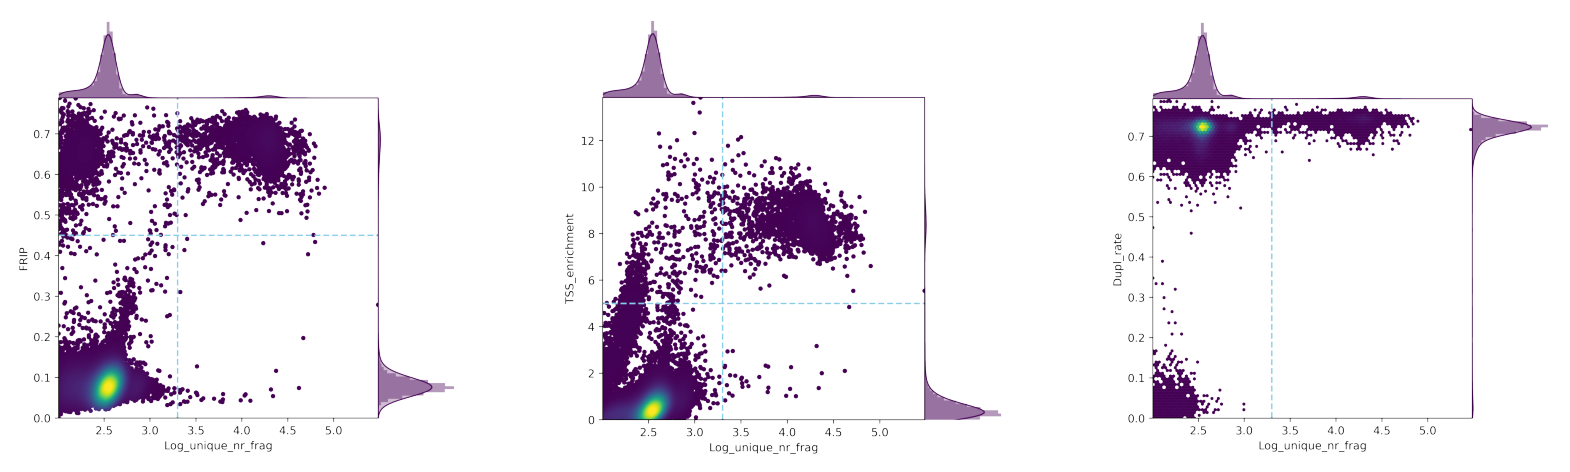

In [ ]:
# Plot barcode stats in one figure
fig=plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
bc_passing_filters = {'BS1140':[]}
bc_passing_filters['BS1140'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
pickle.dump(bc_passing_filters, open(os.path.join(work_dir,'scATAC/quality_control/bc_passing_filters.pkl'),'wb'))
print(f"{len(bc_passing_filters['BS1140'])} barcodes passed QC stats")

60951 barcodes passed QC stats


### Creating a cisTopic object and topic modelling

generate a binary count matrix of ATAC-seq fragments over consensus peaks

In [ ]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata_archr.h5ad'))
scRNA_bc = adata.obs_names
cell_data = adata.obs
cell_data['sample_id'] = 'BS1140'
cell_data['celltype'] = cell_data['cluster_archr'].astype(str) # set data type of the ccelltype column to str
del(adata)

In [ ]:
import pickle
fragments_dict = {'BS1140': '/Users/jinhuixin/Master/thesis/aligned_raw_data/BS1140/outs/atac_fragments.tsv.gz'}
path_to_regions = {'BS1140':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}
path_to_blacklist= '/Users/jinhuixin/Master/thesis/pycisTopic/blacklist/hg38-blacklist.v2.bed'
metadata_bc = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'rb'))
bc_passing_filters = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'rb'))

In [ ]:
print(f"{len(list(set(bc_passing_filters['BS1140']) & set(scRNA_bc)))} cell barcodes pass both scATAC-seq and scRNA-seq based filtering")

2546 cell barcodes pass both scATAC-seq and scRNA-seq based filtering


the number of cells is correct here 2546

In [ ]:
# create cisTopic object
from pycisTopic.cistopic_class import *
key = 'BS1140'
cistopic_obj = create_cistopic_object_from_fragments(
                            path_to_fragments=fragments_dict[key],
                            path_to_regions=path_to_regions[key],
                            path_to_blacklist=path_to_blacklist,
                            metrics=metadata_bc[key],
                            valid_bc=list(set(bc_passing_filters[key]) & set(scRNA_bc)),
                            n_cpu=1,
                            project=key,
                            split_pattern='-')
cistopic_obj.add_cell_data(cell_data, split_pattern='-')
print(cistopic_obj)

2022-10-31 15:03:27,248 cisTopic     INFO     Reading data for BS1140
2022-10-31 15:04:35,215 cisTopic     INFO     metrics provided!
2022-10-31 15:04:37,970 cisTopic     INFO     valid_bc provided, selecting barcodes!
2022-10-31 15:04:41,215 cisTopic     INFO     Counting fragments in regions
2022-10-31 15:04:52,402 cisTopic     INFO     Creating fragment matrix
2022-10-31 15:05:03,136 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-10-31 15:05:04,979 cisTopic     INFO     Removing blacklisted regions
2022-10-31 15:05:05,385 cisTopic     INFO     Creating CistopicObject
2022-10-31 15:05:05,831 cisTopic     INFO     Done!
Columns ['sample_id'] will be overwritten
CistopicObject from project BS1140 with n_cells × n_regions = 2546 × 161994


In [ ]:
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

In [ ]:
# choose the optimal topics number
import pickle
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.cistopic_class import *
models = run_cgs_models(cistopic_obj,
                        n_topics = [2,4,10,16,32,48],
                        n_cpu = 7,
                        n_iter = 500,
                        random_state = 555,
                        alpha = 50,
                        alpha_by_topic = True,
                        eta = 0.1,
                        eta_by_topic = False,
                        save_path = None,
                        ignore_reinit_error=True
)

2022-10-31 15:08:02,640	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


(run_cgs_model pid=44940) 2022-10-31 15:08:09,568 cisTopic     INFO     Running model with 32 topics
(run_cgs_model pid=44943) 2022-10-31 15:08:09,567 cisTopic     INFO     Running model with 16 topics
(run_cgs_model pid=44942) 2022-10-31 15:08:09,567 cisTopic     INFO     Running model with 10 topics
(run_cgs_model pid=44944) 2022-10-31 15:08:09,571 cisTopic     INFO     Running model with 2 topics
(run_cgs_model pid=44939) 2022-10-31 15:08:09,567 cisTopic     INFO     Running model with 4 topics
(run_cgs_model pid=44944) 2022-10-31 15:17:53,988 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=44944) 2022-10-31 15:17:54,053 cisTopic     INFO     Running model with 48 topics
(run_cgs_model pid=44939) 2022-10-31 15:21:00,185 cisTopic     INFO     Model with 4 topics done!
(run_cgs_model pid=44942) 2022-10-31 15:25:39,040 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=44943) 2022-10-31 15:27:44,450 cisTopic     INFO     Model with 16 topics done!
(r

In [ ]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/models')):
    os.makedirs(os.path.join(work_dir,'scATAC/models'))

pickle.dump(models, open(os.path.join(work_dir, 'scATAC/models/BS1140_models_500_iter_LDA.pkl'),'wb'))

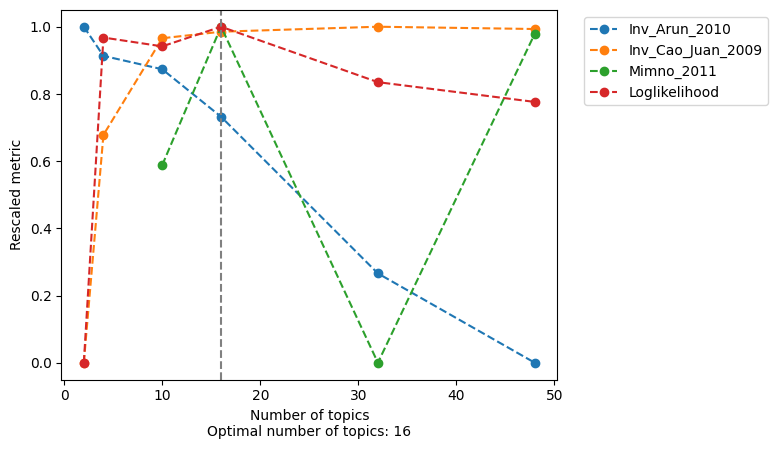

In [ ]:
import pickle
models = pickle.load(open(os.path.join(work_dir, 'scATAC/models/BS1140_models_500_iter_LDA.pkl'), 'rb'))
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=16,
                       return_model=True,
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)

Arun_2010: the better the model, the lower the metric
Juan_2009: the better the model, the lower the metric
Loglikelihood: the better the model, the higher the value
Minmo_2011: the better the model, the higher coherence
16 is ok

In [ ]:
# choose model 16 topics
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj, open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'),'wb'))

### Visualization

use the cell-topic probabilities to generate dimensionality reductions

__kernel crushed here__

In [ ]:
from pycisTopic.clust_vis import *

In [ ]:
run_umap(cistopic_obj, target = 'cell', scale = True)

2022-10-31 16:19:24,082 cisTopic     INFO     Running UMAP


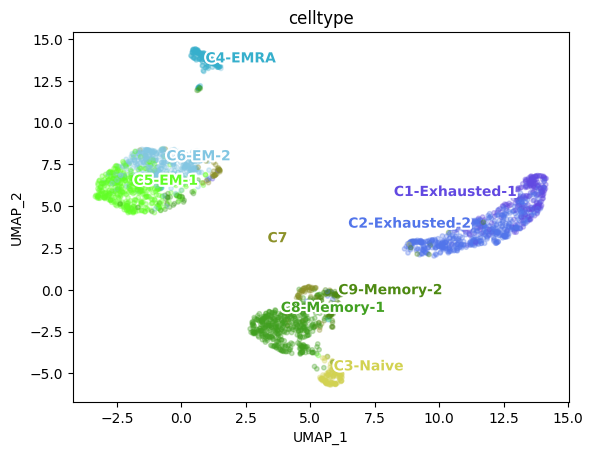

In [ ]:
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['celltype'], alpha = 0.3)

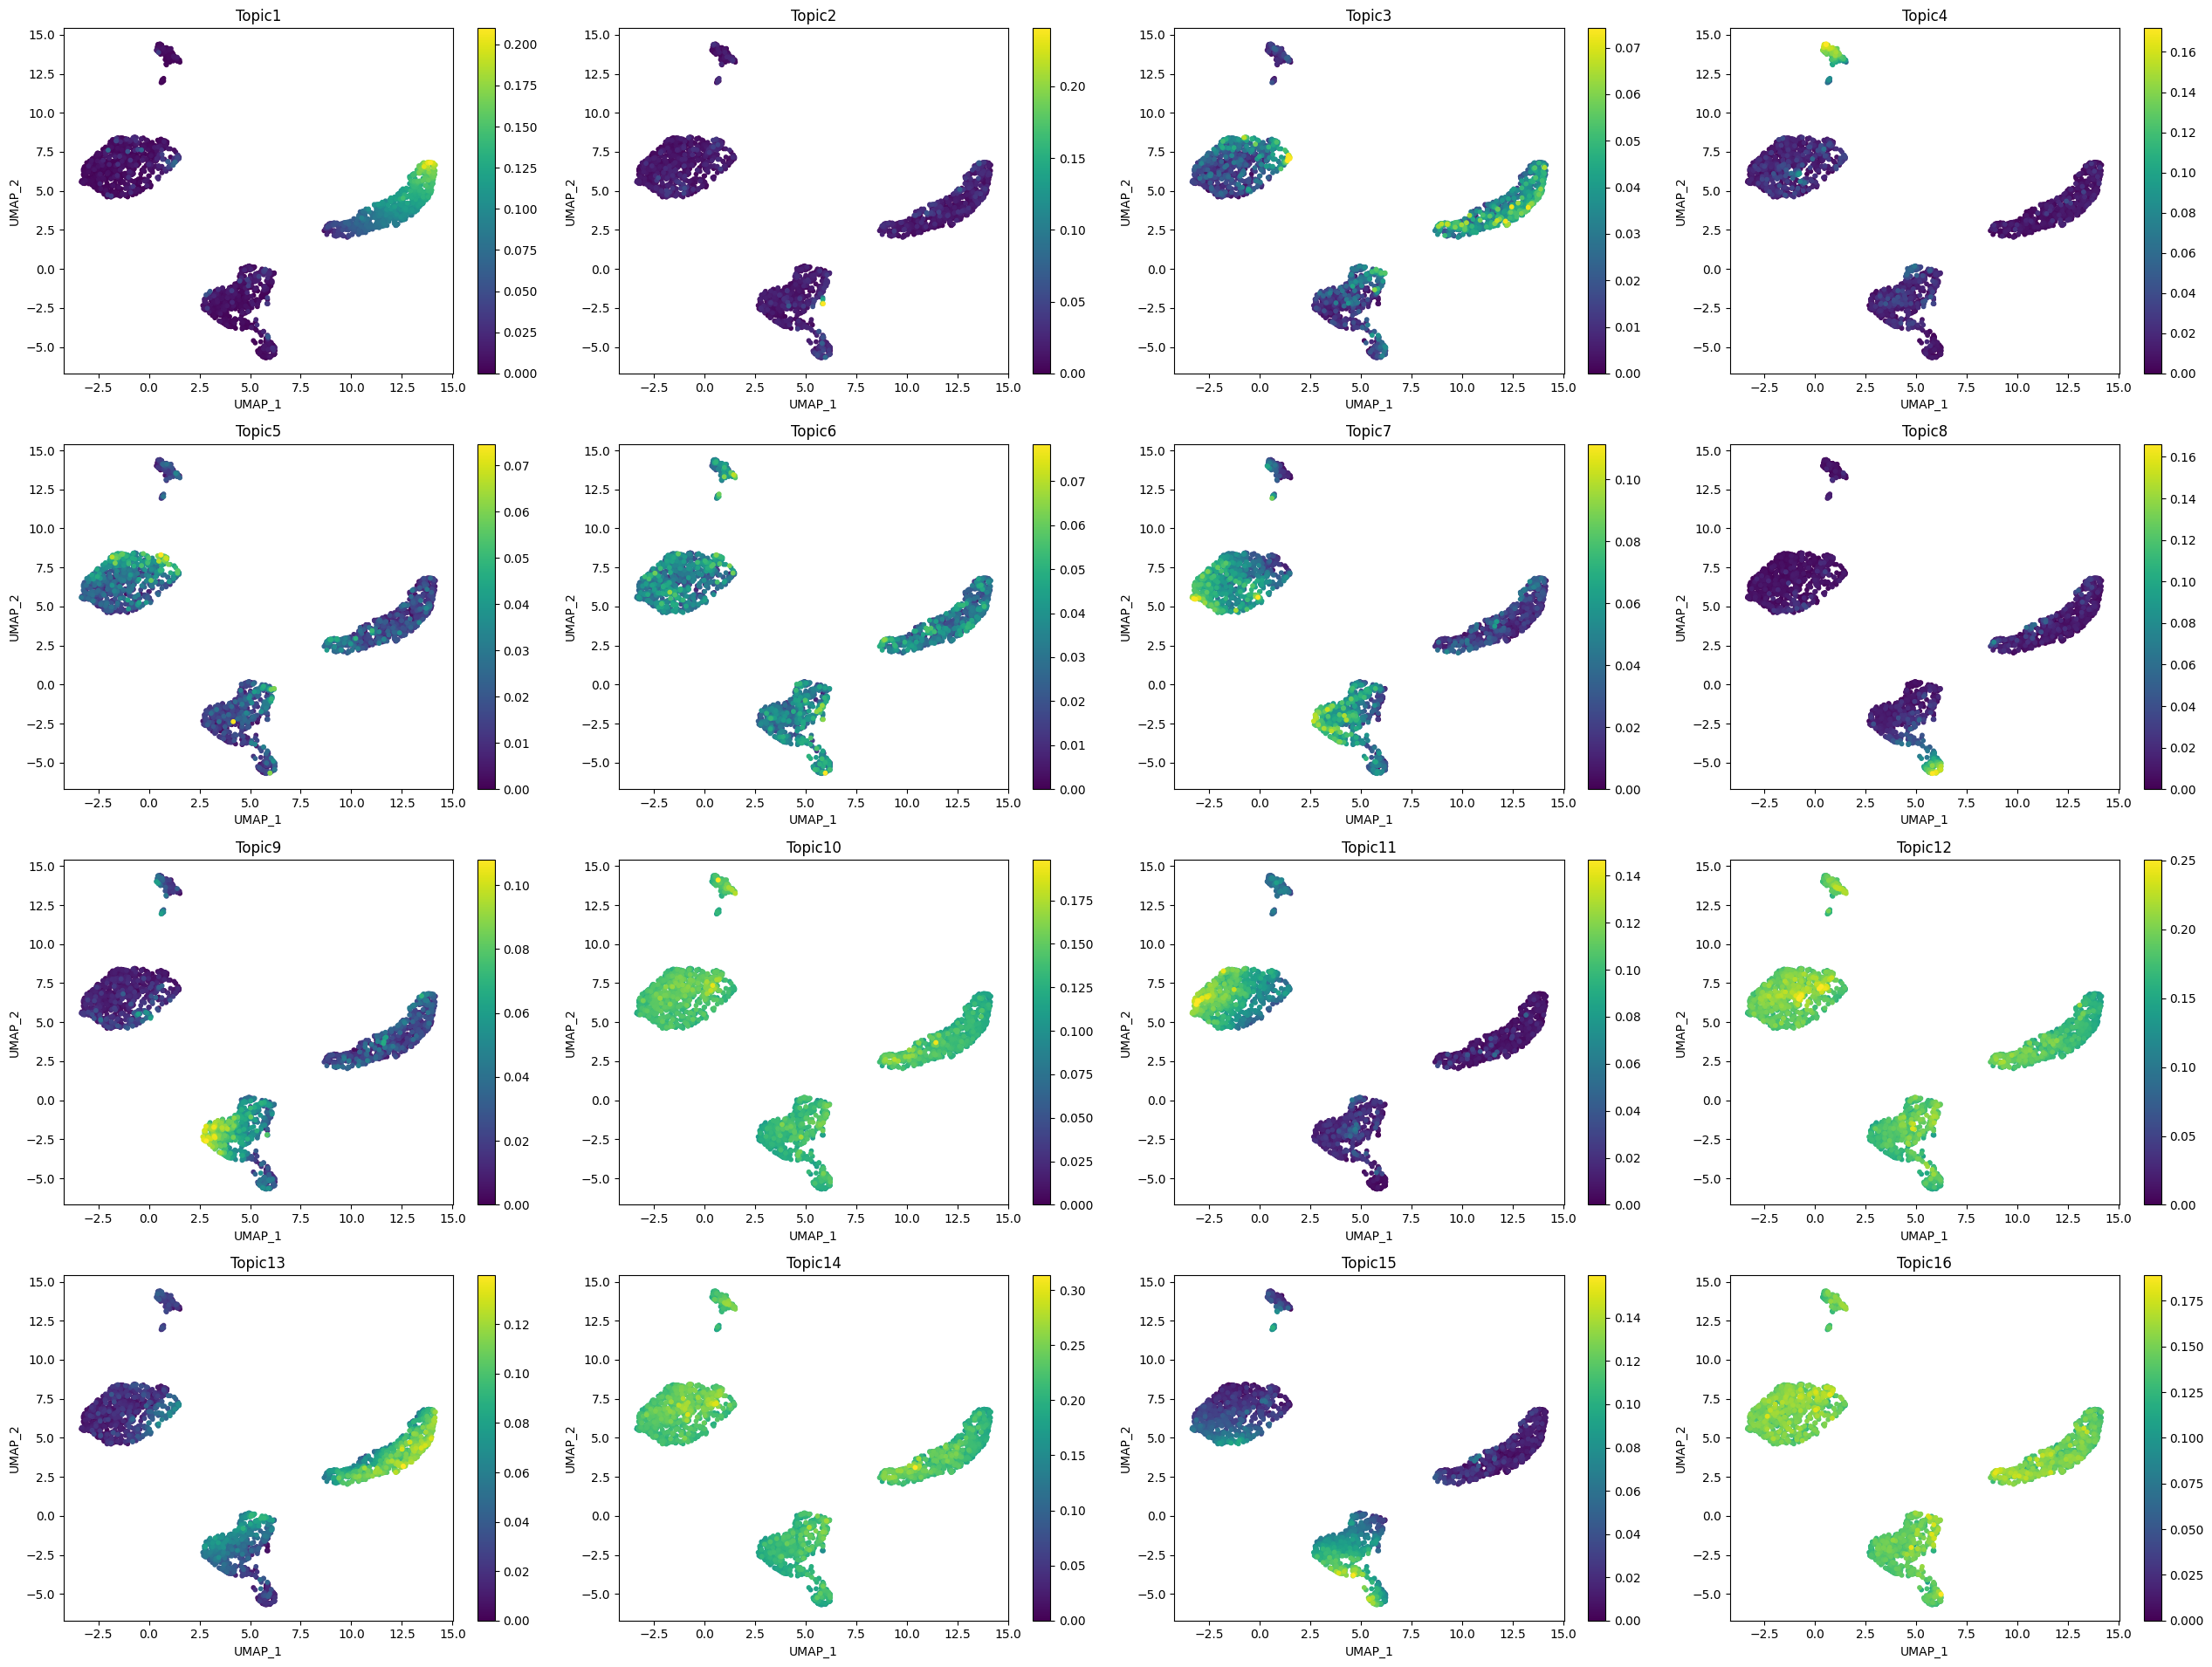

In [ ]:
# plot the cell-topic's cell type specificity
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 4)

## Inferring candidate enhancer regions

In [ ]:
# binarize the topics using the otsu method and by taking the top 3k regions per topic
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method = 'otsu') #binarize
region_bin_topics_top3k = binarize_topics(cistopic_obj, method = 'ntop', ntop = 3000)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# calculate differential accessible regions (DARs) per cell type
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells = None, selected_regions = None, scale_factor = 10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='celltype', var_features=variable_regions, split_pattern = '-')

2022-10-31 16:14:47,691 cisTopic     INFO     Imputing drop-outs
2022-10-31 16:14:49,196 cisTopic     INFO     Scaling
2022-10-31 16:14:50,013 cisTopic     INFO     Keep non zero rows
2022-10-31 16:14:50,814 cisTopic     INFO     Imputed accessibility sparsity: 0.31028790911462056
2022-10-31 16:14:50,814 cisTopic     INFO     Create CistopicImputedFeatures object
2022-10-31 16:14:50,815 cisTopic     INFO     Done!
2022-10-31 16:14:50,815 cisTopic     INFO     Normalizing imputed data
2022-10-31 16:14:58,524 cisTopic     INFO     Done!
2022-10-31 16:14:58,527 cisTopic     INFO     Calculating mean
2022-10-31 16:14:59,166 cisTopic     INFO     Calculating variance
2022-10-31 16:15:03,988 cisTopic     INFO     Done!
2022-10-31 16:15:04,281 cisTopic     INFO     Formatting data for C1-Exhausted-1
2022-10-31 16:15:04,770 cisTopic     INFO     Computing p-value for C1-Exhausted-1
2022-10-31 16:15:14,639 cisTopic     INFO     Computing log2FC for C1-Exhausted-1
2022-10-31 16:15:15,032 cisTopi

<Figure size 640x480 with 0 Axes>

In [ ]:
# save results
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))
import pickle
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'wb'))

# Motif enrichment analysis using pycistarget

In [ ]:
# load candidate enhancer regions identified in previous step
import pickle
region_bin_topics_otsu = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'rb'))
region_bin_topics_top3k = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'rb'))
markers_dict = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'rb'))

In [ ]:
# convert to dictionary of pyranges objects
import pyranges as pr
from pycistarget.utils import region_names_to_coordinates
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['topics_top_3'] = {}
region_sets['DARs'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] # only keep regions on known chromosomes
    region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for topic in region_bin_topics_top3k.keys():
    regions = region_bin_topics_top3k[topic].index[region_bin_topics_top3k[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_top_3'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for DAR in markers_dict.keys():
    regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['DARs'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))

In [ ]:
list(markers_dict.keys())[0:5]

['C1-Exhausted-1', 'C2-Exhausted-2', 'C3-Naive', 'C4-EMRA', 'C5-EM-1']

In [ ]:
for key in region_sets.keys():
    print(f'{key}:{region_sets[key].keys()}')

topics_otsu:dict_keys(['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16'])
topics_top_3:dict_keys(['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16'])
DARs:dict_keys(['C1-Exhausted-1', 'C2-Exhausted-2', 'C3-Naive', 'C4-EMRA', 'C5-EM-1', 'C6-EM-2', 'C7', 'C8-Memory-1', 'C9-Memory-2'])


In [ ]:
db_fpath = motif_annot_fpath = "/Users/jinhuixin/Master/thesis/GRN/data"

In [ ]:
# database used for the cistarget analysis and DEM analysis provided by developer
# https://scenicplus.readthedocs.io/en/latest/pbmc_multiome_tutorial.html#Cistarget-databases
rankings_db = os.path.join(db_fpath, 'hg38_screen_v10_clust.regions_vs_motifs.rankings.feather')
scores_db =  os.path.join(db_fpath, 'hg38_screen_v10_clust.regions_vs_motifs.scores.feather')
motif_annotation = os.path.join(motif_annot_fpath, 'motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl')

In [ ]:
if not os.path.exists(os.path.join(work_dir,'motifs')):
    os.makedirs(os.path.join(work_dir,'motifs'))

In [ ]:
from scenicplus.wrappers.run_pycistarget import run_pycistarget
run_pycistarget(
    region_sets = region_sets_test,
    species = 'homo_sapiens',
    save_path = os.path.join(work_dir, 'motifs'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    path_to_motif_annotations = motif_annotation,
    run_without_promoters = True,
    n_cpu = 7,
    annotation_version = 'v10nr_clust',
    ignore_reinit_error=True
)

2022-10-31 16:42:19,806 pycisTarget_wrapper INFO     BS1140/motifs folder already exists.
2022-10-31 16:42:20,903 pycisTarget_wrapper INFO     Loading cisTarget database for topics_otsu
2022-10-31 16:42:20,903 cisTarget    INFO     Reading cisTarget database
2022-10-31 16:43:18,175 pycisTarget_wrapper INFO     Running cisTarget for topics_otsu
(ctx_internal_ray pid=48081) 2022-10-31 16:43:26,903 cisTarget    INFO     Running cisTarget for Topic1 which has 4493 regions
2022-10-31 16:47:58,840 cisTarget    INFO     Done!
2022-10-31 16:47:58,844 pycisTarget_wrapper INFO     BS1140/motifs/CTX_topics_otsu_All folder already exists.
2022-10-31 16:47:58,949 pycisTarget_wrapper INFO     Running cisTarget without promoters for topics_otsu
(ctx_internal_ray pid=48252) 2022-10-31 16:48:12,500 cisTarget    INFO     Running cisTarget for Topic1 which has 3913 regions
2022-10-31 16:52:35,958 cisTarget    INFO     Done!
2022-10-31 16:52:35,977 pycisTarget_wrapper INFO     BS1140/motifs/CTX_topics_ots

In [ ]:
import dill
menr = dill.load(open(os.path.join(work_dir, 'motifs_euler/menr.pkl'), 'rb'))

In [ ]:
# check results
menr['DEM_topics_otsu_All'].DEM_results('Topic4')

,Logo,Contrast,Direct_annot,Orthology_annot,Log2FC,Adjusted_pval,Mean_fg,Mean_bg,Motif_hit_thr,Motif_hits
metacluster_147.3,,Topic4,"TBX21, TBX18, TBX22, ZNF18, TBX20, TBX15, MGA, TBX1, TBX19","MGA, TBX21",0.96397,0.0046,0.58612,0.300471,3.0,307.0
metacluster_147.6,,Topic4,"TBX21, TBXT, TBX6, TBX20, TBX15, MGA, TBX1, TBX19","TBX6, TBX18",0.94165,0.0046,0.50673,0.263822,3.0,241.0
cisbp__M00832,,Topic4,NaN,TBX1,0.828757,0.000142,1.08831,0.612734,3.0,738.0
metacluster_147.2,,Topic4,"TBX21, TBR1, TBX22, TBX10, TBX3, TBX20, TBX15, TBX2, TBX1",TBX20,0.762593,0.0046,0.566815,0.334101,3.0,270.0
metacluster_47.6,,Topic4,FOXH1,NaN,0.662823,0.02685,0.508919,0.321454,3.0,223.0
kznf__ZNF18_Imbeault2017_OM_RCADE,,Topic4,ZNF18,NaN,0.628241,0.000221,1.346676,0.871252,3.0,1147.0
tfdimers__MD00045,,Topic4,"ZNF354C, STAT6",NaN,0.60802,0.032775,0.678472,0.445143,3.0,407.0
metacluster_158.2,,Topic4,ZNF789,NaN,0.586322,0.003645,0.807164,0.537602,3.0,481.0
transfac_pro__M06202,,Topic4,ZXDB,NaN,0.571261,0.000021,1.551879,1.044458,3.0,1272.0
metacluster_147.1,,Topic4,"TBX21, TBX1, TBR1, TBXT, TBX3, TBX20, TBX2, EOMES","TBX6, TBXT, TBR1, EOMES",0.562064,0.000348,1.219854,0.826247,3.0,671.0


# Inferring enhancer-driven GRNs using SCENIC+

In [ ]:
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata_archr.h5ad')) # preprocessed scRNA result
cistopic_obj = dill.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb')) # preprocessed scATAC results
menr = dill.load(open(os.path.join(work_dir, 'motifs_euler/menr.pkl'), 'rb')) # preprocessed scATAC results

/var/folders/73/t_19bmpd5m7bnvd_88sxp6lw0000gn/T/ipykernel_78415/1337946795.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [ ]:
# create a SCENIC+ object to store gene expression, chromatin accessibility, motif enrichment results and cell/region/gene metadata
from scenicplus.scenicplus_class import create_SCENICPLUS_object
import numpy as np
scplus_obj = create_SCENICPLUS_object(
    GEX_anndata=adata.raw.to_adata(),
    cisTopic_obj=cistopic_obj,
    menr = menr,
    bc_transform_func=lambda x: f'{x}-BS1140' # function to convert scATAC barcodes to scRNA ones
)
scplus_obj.X_EXP = np.array(scplus_obj.X_EXP.todense())
scplus_obj

2022-11-01 10:53:02,389 cisTopic     INFO     Imputing drop-outs
2022-11-01 10:53:03,876 cisTopic     INFO     Scaling
2022-11-01 10:53:04,858 cisTopic     INFO     Keep non zero rows
2022-11-01 10:53:05,622 cisTopic     INFO     Imputed accessibility sparsity: 0.31028790911462056
2022-11-01 10:53:05,622 cisTopic     INFO     Create CistopicImputedFeatures object
2022-11-01 10:53:05,623 cisTopic     INFO     Done!


SCENIC+ object with n_cells x n_genes = 2546 x 19979 and n_cells x n_regions = 2546 x 154223
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
	metadata_cell:'GEX_n_genes', 'GEX_doublet_score', 'GEX_predicted_doublet', 'GEX_n_genes_by_counts', 'GEX_total_counts', 'GEX_total_counts_mt', 'GEX_pct_counts_mt', 'GEX_louvain_res_1.0', 'GEX_celltype', 'GEX_cluster_archr', 'ACC_Total_nr_frag', 'ACC_cisTopic_log_nr_frag', 'ACC_barcode', 'ACC_Total_nr_frag_in_regions', 'ACC_Log_total_nr_frag', 'ACC_Log_unique_nr_frag', 'ACC_cisTopic_nr_frag', 'ACC_Dupl_rate', 'ACC_Dupl_nr_frag', 'ACC_cisTopic_log_nr_acc', 'ACC_FRIP', 'ACC_TSS_enrichment', 'ACC_cisTopic_nr_acc', 'ACC_Unique_nr_frag', 'ACC_Unique_nr_

In [ ]:
# select a optimal biomart host
ensembl_version_dict = {'105': 'http://www.ensembl.org',
                        '104': 'http://may2021.archive.ensembl.org/',
                        '103': 'http://feb2021.archive.ensembl.org/',
                        '102': 'http://nov2020.archive.ensembl.org/',
                        '101': 'http://aug2020.archive.ensembl.org/',
                        '100': 'http://apr2020.archive.ensembl.org/',
                        '99': 'http://jan2020.archive.ensembl.org/',
                        '98': 'http://sep2019.archive.ensembl.org/',
                        '97': 'http://jul2019.archive.ensembl.org/',
                        '96': 'http://apr2019.archive.ensembl.org/',
                        '95': 'http://jan2019.archive.ensembl.org/',
                        '94': 'http://oct2018.archive.ensembl.org/',
                        '93': 'http://jul2018.archive.ensembl.org/',
                        '92': 'http://apr2018.archive.ensembl.org/',
                        '91': 'http://dec2017.archive.ensembl.org/',
                        '90': 'http://aug2017.archive.ensembl.org/',
                        '89': 'http://may2017.archive.ensembl.org/',
                        '88': 'http://mar2017.archive.ensembl.org/',
                        '87': 'http://dec2016.archive.ensembl.org/',
                        '86': 'http://oct2016.archive.ensembl.org/',
                        '80': 'http://may2015.archive.ensembl.org/',
                        '77': 'http://oct2014.archive.ensembl.org/',
                        '75': 'http://feb2014.archive.ensembl.org/',
                        '54': 'http://may2009.archive.ensembl.org/'}

import pybiomart as pbm
def test_ensembl_host(scplus_obj, host, species):
    dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
    annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
    annot.columns = ['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    annot['Chromosome'] = annot['Chromosome'].astype('str')
    filter = annot['Chromosome'].str.contains('CHR|GL|JH|MT')
    annot = annot[~filter]
    annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    gene_names_release = set(annot['Gene'].tolist())
    ov=len([x for x in scplus_obj.gene_names if x in gene_names_release])
    print('Genes recovered: ' + str(ov) + ' out of ' + str(len(scplus_obj.gene_names)))
    return ov

n_overlap = {}
for version in ensembl_version_dict.keys():
    print(f'host: {version}')
    try:
        n_overlap[version] =  test_ensembl_host(scplus_obj, ensembl_version_dict[version], 'hsapiens')
    except:
        print('Host not reachable')
v = sorted(n_overlap.items(), key=lambda item: item[1], reverse=True)[0][0]
print(f"version: {v} has the largest overlap, use {ensembl_version_dict[v]} as biomart host")

host: 105
Genes recovered: 15623 out of 19979
host: 104
Genes recovered: 15735 out of 19979
host: 103
Genes recovered: 19516 out of 19979
host: 102
Genes recovered: 19556 out of 19979
host: 101
Genes recovered: 19623 out of 19979
host: 100
Genes recovered: 19725 out of 19979
host: 99
Genes recovered: 19760 out of 19979
host: 98
Genes recovered: 19957 out of 19979
host: 97
Genes recovered: 19753 out of 19979
host: 96
Genes recovered: 19234 out of 19979
host: 95
Genes recovered: 19117 out of 19979
host: 94
Genes recovered: 19059 out of 19979
host: 93
Genes recovered: 18940 out of 19979
host: 92
Genes recovered: 18856 out of 19979
host: 91
Genes recovered: 18720 out of 19979
host: 90
Genes recovered: 18700 out of 19979
host: 89
Host not reachable
host: 88
Host not reachable
host: 87
Host not reachable
host: 86
Host not reachable
host: 80
Genes recovered: 15229 out of 19979
host: 77
Genes recovered: 15021 out of 19979
host: 75
Host not reachable
host: 54
Host not reachable
version: 98 has 

In [ ]:
# set the biomart host
biomart_host = "http://sep2019.archive.ensembl.org/"

download list of known human TFs

In [ ]:
!wget -O pbmc_tutorial/data/utoronto_human_tfs_v_1.01.txt  http://humantfs.ccbr.utoronto.ca/download/v_1.01/TF_names_v_1.01.txt

 download a the program bedToBigBed this will be used to generate files which can be uploaded to the UCSC genome browser

In [ ]:
!wget -O pbmc_tutorial/bedToBigBed http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bedToBigBed
!chmod +x pbmc_tutorial/bedToBigBed

In [ ]:
#only keep the first two columns of the PCA embedding in order to be able to visualize this in SCope
scplus_obj.dr_cell['GEX_X_pca'] = scplus_obj.dr_cell['GEX_X_pca'].iloc[:, 0:2]
#scplus_obj.dr_cell['GEX_rep'] = scplus_obj.dr_cell['GEX_rep'].iloc[:, 0:2]

In [ ]:
# computation done on cluster
tmp_dir = '/Users/jinhuixin/tmp'
from scenicplus.wrappers.run_scenicplus import run_scenicplus
try:
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['GEX_celltype'],
        species = 'hsapiens',
        assembly = 'hg38',
        tf_file = '/Users/jinhuixin/Master/thesis/GRN/pbmc_tutorial/data/utoronto_human_tfs_v_1.01.txt',
        save_path = os.path.join(work_dir, 'scenicplus'),
        biomart_host = biomart_host,
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = True,
        calculate_DEGs_DARs = True,
        export_to_loom_file = True,
        export_to_UCSC_file = True,
        path_bedToBigBed = '/Users/jinhuixin/Master/thesis/GRN/pbmc_tutorial',
        n_cpu = 7,
        _temp_dir = os.path.join(tmp_dir, 'ray_spill'))
except Exception as e:
    #in case of failure, still save the object
    dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)
    raise(e)

2022-11-01 13:23:37,372 SCENIC+_wrapper INFO     BS1140/scenicplus folder already exists.
2022-11-01 13:23:37,374 SCENIC+_wrapper INFO     Inferring region to gene relationships
2022-11-01 13:23:37,724 R2G          INFO     Calculating region to gene importances, using GBM method
2022-11-01 13:39:04,143 R2G          INFO     Took 926.4185910224915 seconds
2022-11-01 13:39:04,144 R2G          INFO     Calculating region to gene correlation, using SR method
2022-11-01 13:46:53,149 R2G          INFO     Took 469.00419187545776 seconds
2022-11-01 13:46:58,065 R2G          INFO     Done!
2022-11-01 13:46:58,221 SCENIC+_wrapper INFO     Inferring TF to gene relationships
2022-11-01 13:47:04,026 TF2G         INFO     Calculating TF to gene correlation, using GBM method


In [ ]:
# load scenicplus object generated on euler
scplus_obj = dill.load(open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'rb'))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 2546 x 19979 and n_cells x n_regions = 2546 x 154223
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
	metadata_cell:'GEX_n_genes', 'GEX_doublet_score', 'GEX_predicted_doublet', 'GEX_n_genes_by_counts', 'GEX_total_counts', 'GEX_total_counts_mt', 'GEX_pct_counts_mt', 'GEX_louvain_res_1.0', 'GEX_celltype', 'GEX_cluster_archr', 'ACC_Total_nr_frag', 'ACC_cisTopic_log_nr_frag', 'ACC_barcode', 'ACC_Total_nr_frag_in_regions', 'ACC_Log_total_nr_frag', 'ACC_Log_unique_nr_frag', 'ACC_cisTopic_nr_frag', 'ACC_Dupl_rate', 'ACC_Dupl_nr_frag', 'ACC_cisTopic_log_nr_acc', 'ACC_FRIP', 'ACC_TSS_enrichment', 'ACC_cisTopic_nr_acc', 'ACC_Unique_nr_frag', 'ACC_Unique_nr_

# Output of SCENIC+

## Gene expression and chromatin accessibility data

In [ ]:
scplus_obj.to_df('EXP').head() # expression counts

,AL627309.1,AL627309.5,LINC01409,LINC01128,LINC00115,FAM41C,AL645608.6,SAMD11,NOC2L,KLHL17,...,MT-ND4,MT-ND5,MT-ND6,MT-CYB,MAFIP,AC011043.1,AL354822.1,AL592183.1,AC240274.1,AC007325.4
ATTCCTCCATAATCAC-1-BS1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.194697,1.194697,0.0,1.194697,0.0,0.0,0.0,0.0,0.0,0.0
TGAAACTGTTAGAGGG-1-BS1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,2.023663,0.0,2.648440,0.0,0.0,0.0,0.0,0.0,0.0
TTGACATCAGTTTGTG-1-BS1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.772823,2.140287,0.0,3.305294,0.0,0.0,0.0,0.0,0.0,0.0
TGCACTTGTTAGGTGC-1-BS1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,1.440718,0.0,0.0,0.0,0.0,0.0,0.0
CCCAAACCAGGCAAGC-1-BS1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,2.628536,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
scplus_obj.to_df('ACC').head() # accessibility

,ATTCCTCCATAATCAC-1-BS1140,TGAAACTGTTAGAGGG-1-BS1140,TTGACATCAGTTTGTG-1-BS1140,TGCACTTGTTAGGTGC-1-BS1140,CCCAAACCAGGCAAGC-1-BS1140,CACTGACCAAGTGTCC-1-BS1140,GATTTGCAGGTGTCCA-1-BS1140,TTAGCAGGTTTAGTCC-1-BS1140,AGGTAACCATCCCTCA-1-BS1140,GCGAAGCCAACTAGCC-1-BS1140,...,CGCCTCATCACTAAGC-1-BS1140,CAAATCATCTGCAACG-1-BS1140,CATAGCTAGGGTGAAC-1-BS1140,CTTCACTCAATGAGGT-1-BS1140,GTGCTGATCGCAAACT-1-BS1140,CGCATGATCCTCACTA-1-BS1140,GCTTTCATCATCAGTA-1-BS1140,AGCACTAGTACCGAAC-1-BS1140,GGGCAATAGGTAAGGC-1-BS1140,GCAAGTCGTGTTTCAC-1-BS1140
GL000194.1:114742-115242,2,3,2,2,2,3,2,2,2,2,...,3,2,2,2,3,2,2,2,3,2
GL000194.1:101154-101654,7,9,7,8,6,17,7,7,5,4,...,11,5,10,7,8,5,7,6,9,5
GL000195.1:92476-92976,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GL000195.1:131013-131513,0,0,0,0,0,0,1,0,1,1,...,0,0,0,1,0,1,0,0,0,0
GL000195.1:30584-31084,16,13,17,15,18,12,16,15,21,21,...,13,20,13,20,15,22,17,17,15,20


## Cell, region and gene metadata

In [ ]:
scplus_obj.metadata_cell.head() # cell metadata

,GEX_n_genes,GEX_doublet_score,GEX_predicted_doublet,GEX_n_genes_by_counts,GEX_total_counts,GEX_total_counts_mt,GEX_pct_counts_mt,GEX_louvain_res_1.0,GEX_celltype,GEX_cluster_archr,...,ACC_doublet_score,ACC_predicted_doublet,ACC_n_genes_by_counts,ACC_total_counts,ACC_total_counts_mt,ACC_pct_counts_mt,ACC_louvain_res_1.0,ACC_celltype,ACC_cluster_archr,ACC_sample_id
ATTCCTCCATAATCAC-1-BS1140,2069.0,0.031680,False,2068.0,4343.0,11.0,0.253281,M-IL7R+,M-IL7R+,C8-Memory-1,...,0.031680,False,2068.0,4343.0,11.0,0.253281,M-IL7R+,C8-Memory-1,C8-Memory-1,BS1140
TGAAACTGTTAGAGGG-1-BS1140,969.0,0.072093,False,967.0,1523.0,19.0,1.247538,Ex,Ex,C2-Exhausted-2,...,0.072093,False,967.0,1523.0,19.0,1.247538,Ex,C2-Exhausted-2,C2-Exhausted-2,BS1140
TTGACATCAGTTTGTG-1-BS1140,1413.0,0.222222,False,1409.0,2666.0,74.0,2.775694,M-IL7R+,M-IL7R+,C8-Memory-1,...,0.222222,False,1409.0,2666.0,74.0,2.775694,M-IL7R+,C8-Memory-1,C8-Memory-1,BS1140
TGCACTTGTTAGGTGC-1-BS1140,1634.0,0.081425,False,1631.0,3102.0,11.0,0.354610,M-IL7R+,M-IL7R+,C8-Memory-1,...,0.081425,False,1631.0,3102.0,11.0,0.354610,M-IL7R+,C8-Memory-1,C8-Memory-1,BS1140
CCCAAACCAGGCAAGC-1-BS1140,977.0,0.021739,False,976.0,1556.0,10.0,0.642674,M-CD69+,M-CD69+,C6-EM-2,...,0.021739,False,976.0,1556.0,10.0,0.642674,M-CD69+,C6-EM-2,C6-EM-2,BS1140


In [ ]:
scplus_obj.metadata_genes.head()

,gene_ids,feature_types,genome,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,3,False,3,0.001023,99.897716,3.0,False,0.006147,1.972477,1.508182
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,13,False,13,0.004773,99.556768,14.0,False,0.013088,1.195926,-0.803162
LINC01409,ENSG00000237491,Gene Expression,GRCh38,198,False,197,0.077395,93.283328,227.0,True,0.190262,1.783858,0.946773
LINC01128,ENSG00000228794,Gene Expression,GRCh38,186,False,186,0.071258,93.658370,209.0,False,0.202416,1.536482,0.210478
LINC00115,ENSG00000225880,Gene Expression,GRCh38,21,False,21,0.007160,99.284010,21.0,True,0.026549,1.773981,0.917376


In [ ]:
scplus_obj.metadata_regions.head()

,Chromosome,Start,End,Width,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc
GL000194.1:114742-115242,GL000194.1,114742,115242,500,62,1.792392,62,1.792392
GL000194.1:101154-101654,GL000194.1,101154,101654,500,244,2.387390,203,2.307496
GL000195.1:92476-92976,GL000195.1,92476,92976,500,5,0.698970,5,0.698970
GL000195.1:131013-131513,GL000195.1,131013,131513,500,19,1.278754,18,1.255273
GL000195.1:30584-31084,GL000195.1,30584,31084,500,451,2.654177,400,2.602060


Motif enrichment data

In [ ]:
scplus_obj.menr.keys()

dict_keys(['CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters', 'CTX_DARs_All', 'CTX_DARs_No_promoters', 'DEM_DARs_All', 'DEM_DARs_No_promoters'])

Dimensionality reduction data

In [ ]:
scplus_obj.dr_cell.keys()

dict_keys(['GEX_X_pca', 'GEX_X_umap', 'eRegulons_UMAP', 'eRegulons_tSNE'])

some unstructured info

In [ ]:
scplus_obj.uns.keys()

dict_keys(['Cistromes', 'search_space', 'region_to_gene', 'TF2G_adj', 'eRegulons', 'eRegulon_metadata', 'eRegulon_signatures', 'eRegulon_AUC', 'Pseudobulk', 'TF_cistrome_correlation', 'eRegulon_AUC_thresholds', 'RSS', 'DEGs', 'DARs'])

## The eRegulons entry

In [ ]:
scplus_obj.uns['eRegulons'][0:5]

[eRegulon for TF ARID5B in context frozenset({'positive tf2g', 'Top 15 region-to-gene links per gene', 'positive r2g', 'Top 10 region-to-gene links per gene', 'Cistromes_Unfiltered', 'BASC binarized'}).
 	This eRegulon has 19 target regions and 15 target genes.,
 eRegulon for TF ATF2 in context frozenset({'positive tf2g', 'Top 15 region-to-gene links per gene', 'positive r2g', 'Top 10 region-to-gene links per gene', 'Cistromes_Unfiltered', 'BASC binarized', '0.85 quantile'}).
 	This eRegulon has 18 target regions and 13 target genes.,
 eRegulon for TF ATF3 in context frozenset({'positive tf2g', 'Top 15 region-to-gene links per gene', 'positive r2g', 'Top 10 region-to-gene links per gene', 'Cistromes_Unfiltered', 'BASC binarized', 'Top 5 region-to-gene links per gene', '0.85 quantile', '0.9 quantile', '0.95 quantile'}).
 	This eRegulon has 118 target regions and 51 target genes.,
 eRegulon for TF ATF6 in context frozenset({'positive tf2g', 'Cistromes_Unfiltered', 'BASC binarized', 'posi

In [ ]:
for attr in dir(scplus_obj.uns['eRegulons'][0]):
    if not attr.startswith('_'):
        print(f"{attr}: {getattr(scplus_obj.uns['eRegulons'][0], attr) if not type(getattr(scplus_obj.uns['eRegulons'][0], attr)) == list else getattr(scplus_obj.uns['eRegulons'][0], attr)[0:5]}")

cistrome_name: ARID5B_(517r)
context: frozenset({'positive tf2g', 'Top 15 region-to-gene links per gene', 'positive r2g', 'Top 10 region-to-gene links per gene', 'Cistromes_Unfiltered', 'BASC binarized'})
gsea_adj_pval: None
gsea_enrichment_score: None
gsea_pval: None
in_leading_edge: None
is_extended: False
n_target_genes: 15
n_target_regions: 19
regions2genes: [r2g(region='chr5:157344232-157344732', target='ITK', importance=0.01694017203078059, rho=0.19743390222890106, importance_x_rho=0.003344564268465899, importance_x_abs_rho=0.003344564268465899), r2g(region='chr6:16473114-16473614', target='ATXN1', importance=0.036620395425374805, rho=0.33063230171542995, importance_x_rho=0.012107885629220874, importance_x_abs_rho=0.012107885629220874), r2g(region='chr2:203861321-203861821', target='ICOS', importance=0.030269561376561387, rho=0.3582964469743678, importance_x_rho=0.010845476292694499, importance_x_abs_rho=0.010845476292694499), r2g(region='chr2:203914728-203915228', target='ICOS',

In [ ]:
scplus_obj.uns['eRegulon_metadata'].head()

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho
0,ARID5B_+_+_(19r),ARID5B_+_+_(15g),ARID5B,False,chr5:157344232-157344732,ITK,0.016940,0.197434,0.003345,0.003345,9.205713,1,0.115597,1.064154,1.064154
1,ARID5B_+_+_(19r),ARID5B_+_+_(15g),ARID5B,False,chr6:16473114-16473614,ATXN1,0.036620,0.330632,0.012108,0.012108,1.737764,1,0.111201,0.193241,0.193241
2,ARID5B_+_+_(19r),ARID5B_+_+_(15g),ARID5B,False,chr6:16419719-16420219,ATXN1,0.015978,0.325449,0.005200,0.005200,1.737764,1,0.111201,0.193241,0.193241
3,ARID5B_+_+_(19r),ARID5B_+_+_(15g),ARID5B,False,chr6:16699292-16699792,ATXN1,0.004254,0.159969,0.000680,0.000680,1.737764,1,0.111201,0.193241,0.193241
4,ARID5B_+_+_(19r),ARID5B_+_+_(15g),ARID5B,False,chr2:203861321-203861821,ICOS,0.030270,0.358296,0.010845,0.010845,4.094361,1,0.099097,0.405741,0.405741


In [ ]:
# export cell metadata
scplus_obj.uns['eRegulon_metadata'].to_csv('/Users/jinhuixin/Master/thesis/GRN/BS1140/eRegulon_metadata.csv')

## Simplifying and filtering SCENIC+ output

In [ ]:
# only keep eRegulons with an extended annotation
# discard eRegulons for which the region-to-gene correlation is negative (often noisy)
# rename eRegulons from TF_+_+ to TF_+ and TF_-_+ to TF_-
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


new entries in scplus_obj.uns['eRegulon_metadata_filtered] and scplus_obj.uns['eRegulon_signatures_filtered] 

In [ ]:
scplus_obj.uns['eRegulon_metadata_filtered'].head()

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
0,ARID5B_+_(19r),ARID5B_+_(15g),ARID5B,False,chr5:157344232-157344732,ITK,0.016940,0.197434,0.003345,0.003345,9.205713,1,0.115597,1.064154,1.064154,ARID5B_+_+
1,ARID5B_+_(19r),ARID5B_+_(15g),ARID5B,False,chr6:16473114-16473614,ATXN1,0.036620,0.330632,0.012108,0.012108,1.737764,1,0.111201,0.193241,0.193241,ARID5B_+_+
2,ARID5B_+_(19r),ARID5B_+_(15g),ARID5B,False,chr6:16419719-16420219,ATXN1,0.015978,0.325449,0.005200,0.005200,1.737764,1,0.111201,0.193241,0.193241,ARID5B_+_+
3,ARID5B_+_(19r),ARID5B_+_(15g),ARID5B,False,chr6:16699292-16699792,ATXN1,0.004254,0.159969,0.000680,0.000680,1.737764,1,0.111201,0.193241,0.193241,ARID5B_+_+
4,ARID5B_+_(19r),ARID5B_+_(15g),ARID5B,False,chr2:203861321-203861821,ICOS,0.030270,0.358296,0.010845,0.010845,4.094361,1,0.099097,0.405741,0.405741,ARID5B_+_+


## eRegulon enrichment scores

score the enrichment of eRegulons using the AUCell function. 

In [ ]:
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/region_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/gene_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 7)
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.05,
                normalize= False,
                n_cpu = 7)

In [ ]:
# save for Pando and other analysis
dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj_4Pando.pkl'), 'wb'), protocol=-1)

# Dot-heatmap of top eRs

In [ ]:
import dill
work_dir = '../BS1140'
scplus_obj = dill.load(open(os.path.join(work_dir, 'scenicplus/scplus_obj_4Pando.pkl'), 'rb')) # import scenic+ object

In [ ]:
# add eRegulon cluster celltype
import pandas as pd
eR_celltype = pd.read_csv(work_dir+'/cluster_overlap/eRegulon_celltype.csv', index_col=0)
eR_celltype.head()

,eRegulon_cluster
ATTCCTCCATAATCAC-1-BS1140,1-SP1+MAFF+
TGAAACTGTTAGAGGG-1-BS1140,3-ETS1+ZNF282+
TTGACATCAGTTTGTG-1-BS1140,1-SP1+MAFF+
TGCACTTGTTAGGTGC-1-BS1140,1-SP1+MAFF+
CCCAAACCAGGCAAGC-1-BS1140,8-CREM-BACH2-


In [ ]:
scplus_obj.metadata_cell['eR_celltype'] = eR_celltype # add to scenic+ object meta info

filter some high quality eRegulons to plot using the correlation between TF expression and target region enrichment scores (AUC values)

In [ ]:
# visualize the info on both TF genes expression and region accessibility
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'eR_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based')
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'eR_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based')

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'eR_celltype',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'eR_celltype',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

/Users/jinhuixin/miniforge3/envs/scenicplus/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/jinhuixin/miniforge3/envs/scenicplus/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].head()

,TF,Cistrome,Rho,P-value,Adjusted_p-value
0,NFATC3,NFATC3_+_(18r),0.194411,5.669563e-10,9.785246e-10
1,BATF,BATF_-_(70r),-0.358076,1.284626e-31,3.837408e-31
2,TRPS1,TRPS1_-_(25r),-0.478360,2.567431e-58,1.616788e-57
3,REL,REL_-_(31r),0.022617,4.749794e-01,5.171504e-01
4,KLF2,KLF2_+_(265r),0.723980,3.988406e-163,1.858597e-161


### Calculate the RSS (regulon specificity score) of TFs

In [ ]:
from scenicplus.RSS import *
regulon_specificity_scores(
        scplus_obj,
        variable = 'eR_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_keys = ['Region_based'],
        selected_regulons = [x for x in scplus_obj.uns['selected_eRegulon']['Region_based'] if '-' not in x],
        out_key_suffix = '_filtered')

### Get top eR in each eRegulon cluster

In [ ]:
import scanpy as sc
adata = sc.read_h5ad('/Users/jinhuixin/Master/thesis/GRN/BS1140/eRegulon_cluster/eR_cluster_anndata.h5ad')

In [ ]:
eR_list = list()
for group in range(9): 
    eR_list += sc.get.rank_genes_groups_df(adata, group=str(group))['names'][:10].tolist()

In [ ]:
# gene-based and region-based top eR sets
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x in eR_list]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x in eR_list]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 34 eRegulons


modify some SCENIC+ functions

In [ ]:
import plotnine
from plotnine import ggplot, geom_point, aes, scale_fill_distiller, theme_bw, geom_tile, theme, element_text, element_blank
from plotnine.facets import facet_grid
def generate_dotplot_df_modified(
    scplus_obj: SCENICPLUS,
    size_matrix: pd.DataFrame,
    color_matrix: pd.DataFrame,
    scale_size_matrix: bool = True,
    scale_color_matrix: bool = True,
    group_variable: str = None,
    subset_eRegulons: list = None) -> pd.DataFrame:
    if all(np.isin(size_matrix.columns, scplus_obj.cell_names)):
        size_matrix = size_matrix.T
    if all(np.isin(size_matrix.index, scplus_obj.cell_names)):
        #calculate mean values
        if group_variable is None:
            raise ValueError('group_variable can not be None when size_matrix is a matrix with cell barcodes on one axis.')
        if group_variable not in scplus_obj.metadata_cell.columns:
            raise ValueError('group variable must be a column in scplus_obj.metadata_cell')
        size_matrix = size_matrix.groupby(scplus_obj.metadata_cell[group_variable]).mean()
    if all(np.isin(color_matrix.columns, scplus_obj.cell_names)):
        color_matrix = color_matrix.T
    if all(np.isin(color_matrix.index, scplus_obj.cell_names)):
        #calculate mean values
        if group_variable is None:
            raise ValueError('group_variable can not be None when color_matrix is a matrix with cell barcodes on one axis.')
        if group_variable not in scplus_obj.metadata_cell.columns:
            raise ValueError('group variable must be a column in scplus_obj.metadata_cell')
        color_matrix = color_matrix.groupby(scplus_obj.metadata_cell[group_variable]).mean()
    if not all(np.isin(size_matrix.index, color_matrix.index)):
        raise ValueError('size_matrix and color_matrix should have the same values as index.')
    size_matrix_features = (
        size_matrix.columns.to_list(),                      #full eRegulon name
        [f.split('_(')[0] for f in size_matrix.columns],    #eRegulon name without number of targets
        [f.split('_')[0] for f in size_matrix.columns])     #tf name
    color_matrix_features = (
        color_matrix.columns.to_list(),                      #full eRegulon name
        [f.split('_(')[0] for f in color_matrix.columns],    #eRegulon name without number of targets
        [f.split('_')[0] for f in color_matrix.columns])     #tf name

    #put features in same order
    #both matrices have eRegulons as features
    def _find_idx(l, e):
        return [i for i, v in enumerate(l) if v == e]
    if all(['_(' in x for x in size_matrix_features[0]]) and all(['_(' in x for x in color_matrix_features[0]]):
        if not all(np.isin(size_matrix_features[1], color_matrix_features[1])):
            raise ValueError('When two matrices are given with eRegulons as features then the names of these features (without number of targets) should match!')
        color_matrix = color_matrix.iloc[
            :, flatten_list([_find_idx(color_matrix_features[1], e) for e in size_matrix_features[1]])]
    #size matrix has eRegulons as features but color matrix not
    elif all(['_(' in x for x in size_matrix_features[0]]):
        color_matrix = color_matrix[size_matrix_features[2]]
    #color matrix has eRegulons as features but size matrix not
    elif all(['_(' in x for x in color_matrix_features[0]]):
        size_matrix = size_matrix[color_matrix_features[1]]
    #none of the matrices have eRegulons as features
    else:
        size_matrix = size_matrix[color_matrix_features[1]]
    
    if subset_eRegulons is not None:
        #change to TF names
        subset_eRegulons = [x.split('_(')[0] for x in subset_eRegulons]
        size_matrix = size_matrix[[x for x in size_matrix if x.split('_(')[0] in subset_eRegulons]]
        subset_eRegulons_TF = [x.split('_')[0] for x in subset_eRegulons]
        color_matrix = color_matrix[[x for x in color_matrix if x in subset_eRegulons_TF]]
    
    if scale_size_matrix:
        size_matrix = (size_matrix - size_matrix.min()) / (size_matrix.max() - size_matrix.min())
    if scale_color_matrix:
        color_matrix = (color_matrix - color_matrix.min()) / (color_matrix.max() - color_matrix.min())
    
    size_matrix_df = size_matrix.stack().reset_index()
    color_matrix_df = color_matrix.stack().reset_index()
    size_matrix_df.columns = ['index', 'size_name', 'size_val']
    color_matrix_df.columns = ['index', 'color_name', 'color_val']
    if all(['_(' in x for x in size_matrix_features[0]]) and all(['_(' in x for x in color_matrix_features[0]]):
        size_matrix_df['eRegulon_name'] = [x.split('_(')[0] for x in size_matrix_df['size_name']]
        color_matrix_df['eRegulon_name'] = [x.split('_(')[0] for x in color_matrix_df['color_name']]
        merged_df = size_matrix_df.merge(color_matrix_df, on = ['index', 'eRegulon_name'])
        merged_df['TF'] = [x.split('_')[0] for x in merged_df['eRegulon_name']]
    else:
        size_matrix_df['TF'] = [x.split('_')[0] for x in size_matrix_df['size_name']]
        color_matrix_df['TF'] = [x.split('_')[0] for x in color_matrix_df['color_name']]
        merged_df = size_matrix_df.merge(color_matrix_df, on = ['index', 'TF'])
        if all(['_(' in x for x in size_matrix_features[0]]):
            merged_df['eRegulon_name'] = merged_df['size_name']
        elif all(['_(' in x for x in color_matrix_features[0]]):
            merged_df['eRegulon_name'] = merged_df['color_name']
        else:
            merged_df['eRegulon_name'] = merged_df['TF']

    #for esthetics
    merged_df = merged_df[['index', 'TF', 'eRegulon_name', 'size_name', 'color_name', 'size_val', 'color_val']]
    return merged_df

In [ ]:
def heatmap_dotplot_modified(
    scplus_obj: SCENICPLUS,
    size_matrix: pd.DataFrame,
    color_matrix: pd.DataFrame,
    scale_size_matrix: bool = True,
    scale_color_matrix: bool = True,
    group_variable: str = None,
    subset_eRegulons: list = None,
    sort_by: str = 'color_val',
    index_order: list = None,
    save: str = None,
    figsize: tuple = (5, 8),
    split_repressor_activator: bool = True,
    orientation: str = 'vertical'):
    plotting_df = generate_dotplot_df_modified(
        scplus_obj = scplus_obj,
        size_matrix = size_matrix,
        color_matrix = color_matrix,
        scale_size_matrix = scale_size_matrix,
        scale_color_matrix = scale_color_matrix,
        group_variable = group_variable,
        subset_eRegulons = subset_eRegulons)
    if index_order is not None:
        if len(set(index_order) & set(plotting_df['index'])) != len(set(plotting_df['index'])):
            Warning('not all indices are provided in index_order, order will not be changed!')
        else:
            plotting_df['index'] = pd.Categorical(plotting_df['index'], categories = index_order)
    #sort values
    tmp = plotting_df[['index', 'eRegulon_name', sort_by]
        ].pivot_table(index = 'index', columns = 'eRegulon_name'
        ).fillna(0)['color_val']
    if index_order is not None:
        tmp = tmp.loc[index_order]
    idx_max = tmp.idxmax(axis = 0)
    order = pd.concat([idx_max[idx_max == x] for x in tmp.index.tolist() if len(plotting_df[plotting_df == x]) > 0]).index.tolist()
    plotting_df['eRegulon_name'] = pd.Categorical(plotting_df['eRegulon_name'], categories = order)
    plotnine.options.figure_size = figsize
    if split_repressor_activator:
        plotting_df['repressor_activator'] = ['activator' if '+' in n.split('_')[1] and 'extended' not in n or '+' in n.split('_')[2] and 'extended' in n  else 'repressor' for n in plotting_df['eRegulon_name']]
        if orientation == 'vertical':
            plot = (
                ggplot(plotting_df, aes('index', 'eRegulon_name'))
                + facet_grid(
                    'repressor_activator ~ .', 
                    scales = "free", 
                    space = {'x': [1], 'y': [sum(plotting_df['repressor_activator'] == 'activator'), sum(plotting_df['repressor_activator'] == 'repressor')]})
                + geom_tile(mapping = aes(fill = 'color_val'))
                + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
                + geom_point(
                        mapping = aes(size = 'size_val'),
                        colour = "black")
                + theme(axis_text_x=element_text(rotation=90, hjust=1))
                + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
        elif orientation == 'horizontal':
            plot = (
                ggplot(plotting_df, aes('eRegulon_name', 'index'))
                + facet_grid(
                    '. ~ repressor_activator', 
                    scales = "free", 
                    space = {'y': [1], 'x': [sum(plotting_df['repressor_activator'] == 'activator'), sum(plotting_df['repressor_activator'] == 'repressor')]})
                + geom_tile(mapping = aes(fill = 'color_val'))
                + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
                + geom_point(
                        mapping = aes(size = 'size_val'),
                        colour = "black")
                + theme(axis_text_x=element_text(rotation=90, hjust=1))
                + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
    else:
        if orientation == 'vertical':
            plot = (
                ggplot(plotting_df, aes('index', 'eRegulon_name'))
                + geom_tile(mapping = aes(fill = 'color_val'))
                + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
                + geom_point(
                        mapping = aes(size = 'size_val'),
                        colour = "black")
                + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
        elif orientation == 'horizontal':
            plot = (
                ggplot(plotting_df, aes('eRegulon_name', 'index'))
                + geom_tile(mapping = aes(fill = 'color_val'))
                + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
                + geom_point(
                        mapping = aes(size = 'size_val'),
                        colour = "black")
                + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
    if save is not None:
        plot.save(save)
    else:
        return plot

In [ ]:
# gene-based dot-heatmap of the set of top eRs in all clusters
heatmap_dotplot_modified(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Gene_based'], #specify what to plot as dot sizes, target gene expression in this case
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'eR_celltype',
        subset_eRegulons = selected_eRegulons_gene_sig,
        index_order = ['0-ZSCAN22+EOMES+', '1-SP1+MAFF+', '2-FOXP1+ARID5B+', '3-ETS1+ZNF282+', '4-ZNF442+ZNF526+', '5-TBX21+RARG+', '6-CREM-ELF1+', '7-ZNF385D+RORC+', '8-CREM-BACH2-', '9-EGR1+FOSB+'],
        figsize = (5, 20),
        orientation = 'vertical',
        save = work_dir+'/eRegulon_cluster/heatdotmap_gene_based_top_eRegulon_each_cluster.pdf'
        )

/Users/jinhuixin/miniforge3/envs/scenicplus/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 20 in image.
/Users/jinhuixin/miniforge3/envs/scenicplus/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../BS1140/eRegulon_cluster/heatdotmap_gene_based_top_eRegulon_each_cluster.pdf


In [ ]:
# region-based dot-heatmap of the set of top eRs in all clusters
heatmap_dotplot_modified(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'], #specify what to plot as dot sizes, target gene expression in this case
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'eR_celltype',
        subset_eRegulons = selected_eRegulons_region_sig,
        index_order = ['0-ZSCAN22+EOMES+', '1-SP1+MAFF+', '2-FOXP1+ARID5B+', '3-ETS1+ZNF282+', '4-ZNF442+ZNF526+', '5-TBX21+RARG+', '6-CREM-ELF1+', '7-ZNF385D+RORC+', '8-CREM-BACH2-', '9-EGR1+FOSB+'],
        figsize = (5, 20),
        orientation = 'vertical',
        save = work_dir+'/eRegulon_cluster/heatdotmap_region_based_top_eRegulon_each_cluster.pdf'
        )

/Users/jinhuixin/miniforge3/envs/scenicplus/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 20 in image.
/Users/jinhuixin/miniforge3/envs/scenicplus/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../BS1140/eRegulon_cluster/heatdotmap_region_based_top_eRegulon_each_cluster.pdf
